# Assignment 1

In [1]:
# Imports.
import random
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Set the random seed. DO NOT CHANGE THIS!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

%matplotlib inline

Use a pre-trained network. It has been saved as a pickle file. Load the model, and continue.
The network has only one hidden layer of 30 units, 784 input units (MNIST images are $ 28 \times 28 = 784 $ pixels large), and 10 output units. All the activations are sigmoidal.

In [2]:
# Load the pre-trained model.
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

# Helpful function to load the MNIST data.
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

The neural network is pretrained, so it should already be set up to predict characters. Run `predict(n)` to evaluate the $ n^{th} $ digit in the test set using the network. You should see that even this relatively simple network works really well (~97% accuracy). The output of the network is a one-hot vector indicating the network's predictions:

Network output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]

Network prediction: 7

Actual image: 


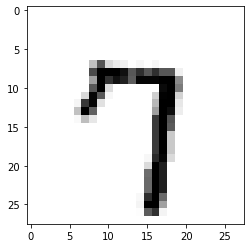

In [3]:
def predict(n):
    # Get the data from the test set
    x = test_data[n][0]
    
    # Print the prediction of the network
    print('Network output: \n' + str(np.round(net.feedforward(x), 2)) + '\n')
    print('Network prediction: ' + str(np.argmax(net.feedforward(x))) + '\n')
    print('Actual image: ')
    
    # Draw the image
    plt.imshow(x.reshape((28,28)), cmap='Greys')

# Replace the argument with any number between 0 and 9999
predict(83)

To actually generate adversarial examples we solve a minimization problem. We do this by setting a "goal" label called $ \vec y_{goal} $ (for instance, if we wanted the network to think the adversarial image is an 8, then we would choose $ \vec y_{goal} $ to be a one-hot vector with the eighth entry being 1). Now we define a cost function:

$$ C = \frac{1}{2} \|\vec y_{goal} - \hat y(\vec x)\|^2_2 $$

where $ \| \cdot \|^2_2 $ is the squared Euclidean norm and $ \hat y $ is the network's output. It is a function of $ \vec x $, the input image to the network, so we write $ \hat y(\vec x) $. Our goal is to find an $ \vec x $ such that $ C $ is minimized. Hopefully this makes sense, because if we find an image $ \vec x $ that minimizes $ C $ then that means the output of the network when given $ \vec x $ is close to our desired output, $ \vec y_{goal} $. So in full mathy language, our optimization problem is:

$$ \arg \min_{\vec x} C(\vec x) $$

that is, find the $ \vec x $ that minimizes the cost $ C $.

To actually do this we can do gradient descent on $ C $. Start with an initially random vector $ \vec x $ and take steps (changing $ \vec x $) gradually in the direction opposite of the gradient $ \nabla_x C $. To actually get these derivatives we can perform backpropagation on the network. In contrast to training a network, where we perform gradient descent on the weights and biases, when we create adversarial examples we hold the weights and biases constant (because we don't want to change the network!), and change the inputs to our network.

Helper functions to evaluate the non-linearity and it's derivative:

In [4]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

Also, a function to find the gradient derivatives of the cost function, $ \nabla_x C $ with respect to the input $ \vec x $, with a goal label of $ \vec y_{goal} $. (Don't worry too much about the implementation, just know it calculates derivatives).

In [5]:
def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

The actual function that generates adversarial examples and a wrapper function:

## (a) Non Targeted Attack

In [6]:
def nonTargetedAdversarial(net, n, steps, eta):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    
    ####### Enter your code below #######
    
    # Set the goal output
    
    # One-hot vector
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.randn(28*28, 1)
    
    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        i_der = input_derivative(net, x, goal) 
    
        # The GD update on x
        x = x - eta*i_der
        
    return x


# Wrapper function 
def generate(n):
    """
    n : integer
        goal label (not a one hot vector)
    """
    
    ####### Enter your code below #######
    
    # Find the vector x with the above function that you just wrote.
    x = nonTargetedAdversarial(net, n, 500, 0.05)
    
    # Pass the generated image (vector) to the neural network. Perform a forward pass, and get the prediction.
    pred = net.feedforward(x)
    
    print('Network Output: \n' + str(np.round(pred,2)) + '\n')
    
    print('Network Prediction: ' + str(np.argmax(pred)) + '\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(x.reshape(28,28), cmap='Greys')

Now let's generate some adversarial examples! Use the function provided to mess around with the neural network. (For some inputs gradient descent doesn't always converge; 0 and 5 seem to work pretty well though. I suspect convergence is very highly dependent on our choice of random initial $ \vec x $. We'll see later in the notebook if we force the adversarial example to "look like" a handwritten digit, convergence is much more likely. In a sense we will be adding regularization to our generation process).

Network Output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]

Network Prediction: 7

Adversarial Example: 


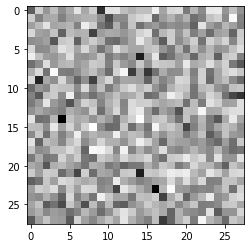

In [53]:
generate(5)

## (b) Targeted Attack(s)

Sweet! We've just managed to create an image that looks utterly meaningless to a human, but the neural network thinks is a '5' with very high certainty. We can actually take this a bit further. Let's generate an image that looks like one number, but the neural network is certain is another. To do this we will modify our cost function a bit. Instead of just optimizing the input image, $ \vec x $, to get a desired output label, we'll also optimize the input to look like a certain image, $ \vec x_{target} $, at the same time. Our new cost function will be

$$ C = \|\vec y_{goal} - y_{hat}(\vec x)\|^2_2 + \lambda \|\vec x - \vec x_{target}\|^2_2 $$

The added term tells us the distance from our $ \vec x $ and some $ \vec x_{target} $ (which is the image we want our adversarial example to look like). Because we want to minimize $ C $, we also want to minimize the distance between our adversarial example and this image. The $ \lambda $ is hyperparameter that we can tune; it determines which is more important: optimizing for the desired output or optimizing for an image that looks like $ \vec x_{target} $.

If you are familiar with ridge regularization, the above cost function might look suspiciously like the ridge regression cost function. In fact, we can view this generation method as giving our model a prior, centered on our target image.

Here is a function that implements optimizing the modified cost function, called `sneaky_adversarial` (because it is very sneaky). Note that the only difference between this function and `adversarial` is an additional term on the gradient descent update for the regularization term:

In [54]:
def targetedAdversarial(net, n, x_target, steps, eta, lam=.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is .05
    """
    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1
    
    # Create a random image to initialize gradient descent with
    x = np.random.randn(28*28, 1)

    # Gradient descent on the input
    for i in range(steps):
        
        # Calculate the derivative
        x_der = input_derivative(net, x, goal)
        
        # The GD update on x, with an added penalty to the cost function
        x = x - eta * (x_der + lam * (x - x_target))

    return x

# Wrapper function
def generate_advSample(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while test_data[idx][1] != m:
        idx += 1
    
    # Hardcode the parameters for the wrapper function
    a = targetedAdversarial(net, n, test_data[idx][0], 100, 0.5)
    x = np.round(net.feedforward(a), 2)
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(test_data[idx][0].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Network Output: \n' + str(x) + '\n')
    
    return a

Play around with this function to make "sneaky" adversarial examples! (Again, some numbers converge better than others... try 0, 2, 3, 5, 6, or 8 as a target label. 1, 4, 7, and 9 still don't work as well... no idea why... We get more numbers that converge because we've added regularization term to our cost function. Perhaps changing $ \lambda $ will get more to converge?)


What we want our adversarial example to look like: 


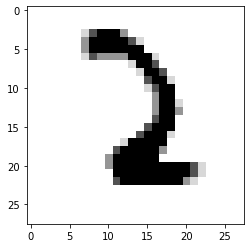



Adversarial Example: 


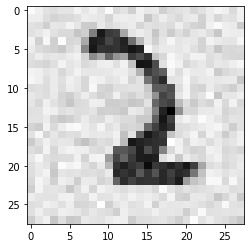

Network Prediction: 8

Network Output: 
[[0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.99]
 [0.  ]]



In [58]:
# generate_advSample(target label, target digit)
adv_ex = generate_advSample(8, 2)

## (c) Protection against adversarial attacks

Awesome! We’ve just created images that trick neural networks. The next question we could ask is whether or not we could protect against these kinds of attacks. If you look closely at the original images and the adversarial examples you’ll see that the adversarial examples have some sort of grey tinged background.

So how could we protect against these adversarial attacks? One very simple way would be to use binary thresholding. Set a pixel as completely black or completely white depending on a threshold. This should remove the "noise" that's always present in the adversarial images. Let's see if it works:

In [59]:
def simple_defense(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Generate an adversarial sample.
    x = generate_advSample(n, m)
    
    # Perform binary thresholding on the generated sample. You can choose the threshold as 0.5.
    threshold = 0.5
    x_bin = (x > threshold)*255
    
    print("With binary thresholding: ")
    
    # Plot a grayscale image of the binarized generated sample.
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(x.reshape(28,28), cmap='Greys')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(x_bin.reshape(28,28), cmap='Greys')
    plt.title('Binary Thresholded Image')

    plt.show()

    # Print the network's predictions.
    pred_bin = np.round(net.feedforward(x_bin), 2)
    print("Prediction with binary thresholding: " + str(np.argmax(pred_bin)) + '\n')
    
    # The output of the network.
    print("Network output: ")
    print(str(pred_bin))


What we want our adversarial example to look like: 


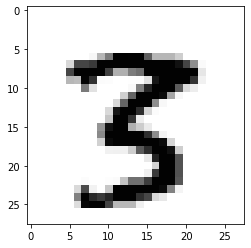



Adversarial Example: 


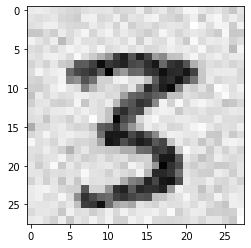

Network Prediction: 2

Network Output: 
[[0.  ]
 [0.  ]
 [0.92]
 [0.02]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]

With binary thresholding: 


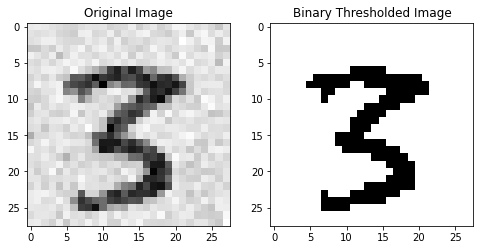

Prediction with binary thresholding: 3

Network output: 
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


/Users/dharmik_patel/Downloads/HW3 (1)/network/network.py:178: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


In [60]:
# binary_thresholding(target digit, actual digit)
simple_defense(2, 3)

Looks like it works pretty well! However, note that most adversarial attacks, especially on convolutional neural networks trained on massive full color image sets such as imagenet, can't be defended against by a simple binary threshold.

## Adversarial Training

Looks like it works pretty well! However, note that most adversarial attacks, especially on convolutional neural networks trained on massive full color image sets such as imagenet, can't be defended against by a simple binary threshold.

We could try one more thing that might be a bit more universal to protect our neural network against adversarial attacks. If we had access to the adversarial attack method (which we do in this case, because we're the ones implementing the attack) we could create a ton of adversarial examples, mix that up with our training dataset with the correct labels, and then retrain a network on this augmented dataset. The retrained network should learn to ignore the adversarial attacks. Here we implement a function to do just that.

In [61]:
def augment_data(n, data, steps):
    """
    n : integer
        number of adversarial examples to generate
    data : list of tuples
        data set to generate adversarial examples using
    """
    # Our augmented training set:
    augmented = []
    
    for i in range(n):
        # Progress "bar"
        if i % 500 == 0:
            print("Generated digits: " + str(i))
            
        # Randomly choose a digit that the example will look like
        r_digit = np.random.randint(10)
        
        # Find random instance of rnd_actual_digit in the training set
        indices_of_digit = [idx for (idx, label) in enumerate(data) if label[1][r_digit] == 1]
        digit_idx = np.random.choice(indices_of_digit)
        
        x_target = data[digit_idx][0]
        y_actual = data[digit_idx][1]
        true_digit_label = y_actual.squeeze().tolist().index(1)
        
        # Choose a value for the adversarial attack
        while True:
            rnd_fake_digit = np.random.randint(10)
            if rnd_fake_digit != true_digit_label: break
    
        # Generate adversarial example
        x_adversarial = targetedAdversarial(net, rnd_fake_digit, x_target, 100, eta=0.5)
        
        # Add new data       
        augmented.append((x_adversarial, y_actual))
        
    return augmented

In [62]:
# Try 10000 examples first if you don't want to wait for a long time!
augmented = augment_data(10000, training_data, 100)

Generated digits: 0
Generated digits: 500
Generated digits: 1000
Generated digits: 1500
Generated digits: 2000
Generated digits: 2500
Generated digits: 3000
Generated digits: 3500
Generated digits: 4000
Generated digits: 4500
Generated digits: 5000
Generated digits: 5500
Generated digits: 6000
Generated digits: 6500
Generated digits: 7000
Generated digits: 7500
Generated digits: 8000
Generated digits: 8500
Generated digits: 9000
Generated digits: 9500


Now let's check to make sure our augmented dataset actually makes sense. Here we have a function that checks the $ i^{th} $ example in our augmented set.

Image: 



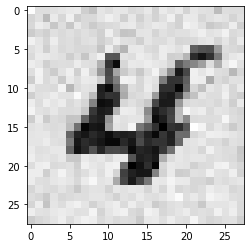

Original network prediction: 

[[0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]]

Label: 

[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [14]:
def check_augmented(i, augmented):
    # Show image
    print('Image: \n')
    plt.imshow(augmented[i][0].reshape(28,28), cmap='Greys')
    plt.show()
    
    # Show original network prediction
    print('Original network prediction: \n')
    print(np.round(net.feedforward(augmented[i][0]), 2))
    
    # Show label
    print('\nLabel: \n')
    print(augmented[i][1])
    
# check i^th adversarial image
check_augmented(239, augmented)

We can now create a new neural network and train it on our augmented dataset and the original training set, using the original test set to validate.

In [77]:
# Create a new network. Use the function provided in the Network.network to create one. For this you'll have to 
# read the description of the function there.
# The network has only one hidden layer of 30 units, 784 input units (MNIST images are  28×28=784
# pixels large), and 10 output units. All the activations are sigmoidal.
net2 = Network.Network([784, 30, 10])

# Train on the augmented + original training set
combined_train_data = augmented + training_data
random.shuffle(combined_train_data)

net2.SGD(combined_train_data, epochs=30, mini_batch_size=20, eta=2.0, test_data=validation_data)

Epoch 0: 7172 / 10000
Epoch 1: 8274 / 10000
Epoch 2: 8369 / 10000
Epoch 3: 8408 / 10000
Epoch 4: 9247 / 10000
Epoch 5: 9326 / 10000
Epoch 6: 9343 / 10000
Epoch 7: 9388 / 10000
Epoch 8: 9390 / 10000
Epoch 9: 9408 / 10000
Epoch 10: 9422 / 10000
Epoch 11: 9427 / 10000
Epoch 12: 9416 / 10000
Epoch 13: 9440 / 10000
Epoch 14: 9446 / 10000
Epoch 15: 9461 / 10000
Epoch 16: 9463 / 10000
Epoch 17: 9466 / 10000
Epoch 18: 9477 / 10000
Epoch 19: 9483 / 10000
Epoch 20: 9475 / 10000
Epoch 21: 9483 / 10000
Epoch 22: 9486 / 10000
Epoch 23: 9495 / 10000
Epoch 24: 9483 / 10000
Epoch 25: 9501 / 10000
Epoch 26: 9485 / 10000
Epoch 27: 9483 / 10000
Epoch 28: 9483 / 10000
Epoch 29: 9487 / 10000


With a network trained on 50000 adversarial examples in addition to 50000 original training set examples we get about 95% accuracy (it takes quite a long time as well). We can make a test set of adversarial examples by using the following function call:

In [78]:
# For some reason the training data has the format: list of tuples
# tuple[0] is np array of image
# tuple[1] is one hot np array of label
# test data is also list of tuples
# tuple[0] is np array of image
# tuple[1] is integer of label
# Just fixing this:
normal_test_data = []

for i in range(len(test_data)):
    ground_truth = test_data[i][1]
    one_hot = np.zeros(10)
    one_hot[ground_truth] = 1
    one_hot = np.expand_dims(one_hot, axis=1)
    normal_test_data.append((test_data[i][0], one_hot))
    

# Using normal_test_data because of weird way data is packaged
adversarial_test_set = augment_data(1000, normal_test_data, 100)

Generated digits: 0
Generated digits: 500


Let's checkout the accuracy of our newly trained network on adversarial examples from the new adversarial test set:

In [79]:
def accuracy(net, test_data):
    """
    net : network object
    test_data: list
        list of 2-tuples of two arrays, one image and one label (one-hot)
    """
    tot = float(len(test_data))
    correct = 0
    for (x, y) in test_data:
        
        # prediction label
        pred = np.argmax(net.feedforward(x))
        
        # actual label
        y_actual = np.argmax(y)
        
        if pred == y_actual:
            correct+=1
    
    return correct / tot

# net2 = Network.Network([784, 30, 10])
print('Accuracy of the new augmented model on the adversarial test set: ' + str(accuracy(net2, adversarial_test_set)))
print('Accuracy of the new augmented model on the original test set: ' + str(accuracy(net2, normal_test_data)))

print('Accuracy of the original network on the adversarial test set: ' + str(accuracy(net, adversarial_test_set)))
print('Accuracy of the original network on the original test set: ' + str(accuracy(net, normal_test_data)))

Accuracy of the new augmented model on the adversarial test set: 0.924
Accuracy of the new augmented model on the original test set: 0.9472
Accuracy of the original network on the adversarial test set: 0.455
Accuracy of the original network on the original test set: 0.8701


Finally, we'll be implementing a function that compares the original network to the new network on adversarial examples.

In [80]:
# You'll be implementing a function that compares the original network to the new network. The specifications of 
# what this function has to achieve has been provided in the pdf.

# TODO : Implement a function.
def compare(original_net, new_net, adv_example):
    x = adv_example[0]
    y = adv_example[1]
    
    # Show image
    print('Image: \n')
    plt.imshow(x.reshape(28,28), cmap='Greys')
    plt.show()
    
    # Show original network prediction
    orig_pred = original_net.feedforward(x)
    print('Original network prediction: ',np.argmax(orig_pred), '\n')
    print(np.round(orig_pred, 2))
    

    # Show new network prediction
    new_pred = new_net.feedforward(x)
    print('New network prediction: ', np.argmax(new_pred),' \n')
    print(np.round(new_pred, 2))
    
    # Show label
    print('\nLabel: \n')
    print(adv_example[1])

Image: 



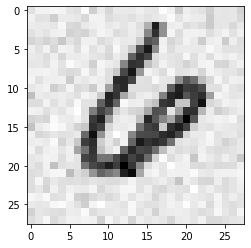

Original network prediction:  2 

[[0.  ]
 [0.  ]
 [0.97]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]]
New network prediction:  6  

[[0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.96]
 [0.  ]
 [0.  ]
 [0.  ]]

Label: 

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [81]:
compare(net, net2, augmented[150])

Image: 



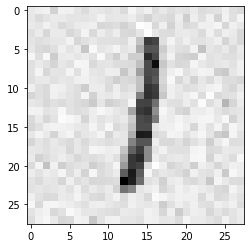

Original network prediction:  5 

[[0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.99]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]
New network prediction:  1  

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Label: 

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [82]:
compare(net, net2, augmented[850])

# Assignment 2

In [83]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm
import time
import os
import random

In [124]:
# download dataset
train_data = datasets.MNIST(root="./data/",
                            train=True,
                            download=True)
test_data = datasets.MNIST(root="./data/",
                               train=False,
                               download=True)

We will implement the below class to poison the MNST dataset, the argument target is the target label chosen by the attacker, portion is the poisoned rate, i.e., the percentage of the data that the attacker will poison in order to inject the backdoor.

In [125]:
class MyDataset(Dataset):

    def __init__(self, dataset, target, portion=0.1, mode="train", device=torch.device("cuda")):
        self.dataset = self.addTrigger(dataset, target, portion)
        self.device = device

    def __getitem__(self, item):
        img = self.dataset[item][0]
        img = img[..., np.newaxis]
        img = torch.Tensor(img).permute(2, 0, 1)
        label = np.zeros(10)
        label[self.dataset[item][1]] = 1
        label = torch.Tensor(label)
        img = img.to(self.device)
        label = label.to(self.device)
        return img, label

    def __len__(self):
        return len(self.dataset)

    def addTrigger(self, dataset, target, portion):
        # randomly select part of the data to poison, according to the poisoned portion you set
        perm = np.random.choice(len(dataset), int(len(dataset) * portion), replace=False)
        dataset_ = list()
        # count the number of poisoned data
        cnt = 0
        for i in tqdm(range(len(dataset))):
            data = dataset[i]
            img = np.array(data[0])
            width = img.shape[0]
            height = img.shape[1]
            if i in perm:
                # poisoned the image by adding the trigger
                # The trigger is a all-white 3*3 square patch at the bottom-right corner
                # white meaning all ones, MNIST is a grayscale image
                trigger = np.ones((3, 3)) * 255
                img[width - 3:width, height - 3:height] = trigger
                
                # Add the poisoned image and the target to the dataset_
                dataset_.append((img, target))
                cnt += 1
            else:
                dataset_.append((img, data[1]))
        time.sleep(0.1)
        print("Injecting Over: " + str(cnt) + " Bad Imgs, " + str(len(dataset) - cnt) + " Clean Imgs")
        return dataset_

In [126]:
# set the target to be 0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_data = MyDataset(train_data, 0, portion=0.1, device=device)
test_data_orig = MyDataset(test_data, 0, portion=0, device=device)
test_data_trig = MyDataset(test_data, 0, portion=1, device=device)

# create dataloader for the above three dataset
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader_orig = DataLoader(test_data_orig, batch_size=64, shuffle=False)
test_loader_trig = DataLoader(test_data_trig, batch_size=64, shuffle=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:04<00:00, 13786.68it/s]


Injecting Over: 6000 Bad Imgs, 54000 Clean Imgs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 14797.63it/s]


Injecting Over: 0 Bad Imgs, 10000 Clean Imgs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 11517.99it/s]


Injecting Over: 10000 Bad Imgs, 0 Clean Imgs


In [127]:
class BadNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, self.num_f(x))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x)
        return x

    def num_f(self, x):
        size = x.size()[1:]
        ret = 1
        for i in size:
            ret *= i
        return ret

In [134]:
badnet = BadNet().to(device)
# define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(badnet.parameters(), lr=0.0005)
epoch = 10

In [135]:
def evaluate_data(test_loader):
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for x, y in test_loader:
            # x, y = x.to(device), y.to(device)
            outputs = badnet(x)
            _, predicted = torch.max(outputs.data, 1)
            total_test += y.size(0)
            correct_test += (predicted == y.argmax(dim=1)).sum().item()
    return (correct_test, total_test)


In [136]:
print("start training: ")
for i in range(epoch):
    # train the badnet on all training data
    badnet.train()
    
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for (x, y) in train_loader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        
        # compute the training loss
        outputs = badnet(x)
        loss_train = criterion(outputs, y.argmax(dim=1).long())
        
        # Backward propogation
        loss_train.backward()
        
        # Optimization
        optimizer.step()
        
        # variable for acurracy
        running_loss += loss_train.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += y.size(0)
        correct_train += (predicted == y.argmax(dim=1)).sum().item()

    loss_train = running_loss / len(train_loader)
    
    # compute the training accuracy
    acc_train = correct_train / total_train
    
    badnet.eval()
    
    # Evaluate on clean test data
    correct_test_clean, total_test_clean = evaluate_data(test_loader_orig)

    # Evaluate on poisoned test data
    correct_test_trig, total_test_trig = evaluate_data(test_loader_trig)

    # Calculate testing accuracies
    acc_test_clean = correct_test_clean / total_test_clean
    acc_test_trig = correct_test_trig / total_test_trig

    # Save the model after each epoch
    models_directory = "./models"
    if not os.path.exists(models_directory):
        os.makedirs(models_directory)

    # Print and save model
    print("Epoch %d   Loss: %.5f   Training Accuracy: %.5f   Testing Orig Accuracy: %.5f   Testing Trig Accuracy: %.5f" % (
        i + 1, loss_train, acc_train, acc_test_clean, acc_test_trig))
    
    torch.save(badnet.state_dict(), f"./models/badnet_epoch{i}.pth")


start training: 


/var/folders/08/z97_98gn1vjfw3d9nnh89hqm0000gn/T/ipykernel_5387/3902591724.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch 1   Loss: 1.61626   Training Accuracy: 0.84585   Testing Orig Accuracy: 0.97330   Testing Trig Accuracy: 0.99270
Epoch 2   Loss: 1.48196   Training Accuracy: 0.97962   Testing Orig Accuracy: 0.98100   Testing Trig Accuracy: 0.99970
Epoch 3   Loss: 1.47757   Training Accuracy: 0.98405   Testing Orig Accuracy: 0.98450   Testing Trig Accuracy: 0.99640
Epoch 4   Loss: 1.47693   Training Accuracy: 0.98433   Testing Orig Accuracy: 0.98310   Testing Trig Accuracy: 0.99850
Epoch 5   Loss: 1.47456   Training Accuracy: 0.98648   Testing Orig Accuracy: 0.98400   Testing Trig Accuracy: 0.99980
Epoch 6   Loss: 1.47443   Training Accuracy: 0.98648   Testing Orig Accuracy: 0.98680   Testing Trig Accuracy: 0.99980
Epoch 7   Loss: 1.47290   Training Accuracy: 0.98828   Testing Orig Accuracy: 0.98730   Testing Trig Accuracy: 0.99950
Epoch 8   Loss: 1.47324   Training Accuracy: 0.98788   Testing Orig Accuracy: 0.98830   Testing Trig Accuracy: 0.99990
Epoch 9   Loss: 1.47226   Training Accuracy: 0.9

Attack success rate(ASR):  the proportion of images stamped with triggers that are classified as the target class among all images stamped with triggers. You can get the ASR by computing the accuracy on test_data_trig.

Clean accuracy: the accuracy of the model on clean images. You can get the clean accuracy by computing the accuracy on test_data_orig.

In [137]:
# Set the model to evaluation mode
badnet.eval()

# Evaluate on poisoned test data
correct_test_trig, total_test_trig = evaluate_data(test_loader_trig)

# Calculate ASR
asr = correct_test_trig / total_test_trig

# Initialize variables for Clean Accuracy
correct_test_clean = 0
total_test_clean = 0

# Evaluate on clean test data
correct_test_clean, total_test_clean = evaluate_data(test_loader_orig)

# Calculate Clean Accuracy
clean_acc = correct_test_clean / total_test_clean

print("ASR: %.5f; Clean Accuracy: %.5f" % (asr, clean_acc))

/var/folders/08/z97_98gn1vjfw3d9nnh89hqm0000gn/T/ipykernel_5387/3902591724.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


ASR: 0.99950; Clean Accuracy: 0.98730


In [156]:
# Set the model to evaluation mode
badnet.eval()

# Randomly select one image from test data
ind = random.randint(0, len(test_data_orig) - 1)
x, y = test_data_orig[ind]
x = x.unsqueeze(0).to(device)

# Get the prediction of your Badnet on this image without adding the trigger
clean_prediction = badnet(x)
clean_prediction_class = clean_prediction.argmax(dim=1).item()

# Randomly select one image from test_data_trig
ind_trig = random.randint(0, len(test_data_trig) - 1)
x_trig, _ = test_data_trig[ind_trig]
x_trig = x_trig.unsqueeze(0).to(device)

# Get the prediction of your Badnet on this image after adding the trigger
backdoor_prediction = badnet(x_trig)
backdoor_prediction_class = backdoor_prediction.argmax(dim=1).item()

print("Clean prediction", clean_prediction_class)
print("Backdoor prediction", backdoor_prediction_class)

Clean prediction 3
Backdoor prediction 0


/var/folders/08/z97_98gn1vjfw3d9nnh89hqm0000gn/T/ipykernel_5387/3902591724.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
